In [7]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
from omegaconf import OmegaConf
from gluefactory.datasets import get_dataset
from gluefactory.utils.tensor import batch_to_device
import torch

torch.set_grad_enabled(True)
images = Path("assets")


from gluefactory.models import get_model
from matplotlib import pyplot as plt
import numpy as np

In [8]:
conf = OmegaConf.load(file_="../gluefactory/configs/superpoint+simpleglue_homography_debug.yaml")

In [9]:
device= 'cpu'

In [10]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/24/2025 14:57:54 gluefactory.datasets.base_dataset INFO] Creating dataset HomographyDataset
[08/24/2025 14:57:54 gluefactory.datasets.homographies INFO] Found 4 images in list file.


In [11]:
train_loader = dataset.get_data_loader("train", distributed=False)


In [12]:
model = get_model(conf.model.name)(conf.model).to(device)

In [13]:
# train the model
torch.autograd.set_detect_anomaly(False)
tot_steps = 1
lr = 1e-5
params = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
all_params = [p for n, p in params]
optimizer = torch.optim.Adam(all_params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
        lr, tot_steps, pct_start=0.01, cycle_momentum=False, anneal_strategy='linear')

step = 0
data = next(iter(train_loader))
data = batch_to_device(data, device, non_blocking=True)
data.update({'tr_logvar': False})
start_tr_logvar = tot_steps // 20
while(step < tot_steps):
    # for _, data in enumerate(train_loader):
        if step >= start_tr_logvar:
            data.update({'tr_logvar': True})
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        losses, _ = model.loss(pred, data)
        loss = torch.mean(losses["total"])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, conf.train.clip_grad)
        optimizer.step()
        scheduler.step()
        # print(f"Step {step}/{tot_steps}- lr: {scheduler.get_last_lr()} - Loss total: {loss.item()}, Last rpr Loss: {losses['last_rp'].item()}, Last lagvar Loss: {losses['last_logvar'].item()}")
        step += 1

kpts shape and size shape torch.Size([2, 512, 2]) torch.Size([2, 2])
kpts shape and size shape torch.Size([2, 512, 2]) torch.Size([2, 2])


In [15]:
for k in losses:
    print(f"{k}: {losses[k]}")

total: tensor([3588.6411], grad_fn=<AddBackward0>)
last_rp: tensor([2133.0762])
last_logvar: tensor([0.8377])


In [16]:
for k in data:
    print(f"{k}")

name
original_image_size
H_0to1
idx
view0
view1
tr_logvar


In [17]:
for k in pred:
    print(k, pred[k].shape)

keypoints0 torch.Size([1, 512, 2])
keypoint_scores0 torch.Size([1, 512])
descriptors0 torch.Size([1, 512, 256])
keypoints1 torch.Size([1, 512, 2])
keypoint_scores1 torch.Size([1, 512])
descriptors1 torch.Size([1, 512, 256])
matches0 torch.Size([1, 512])
matches1 torch.Size([1, 512])
matching_scores0 torch.Size([1, 512])
matching_scores1 torch.Size([1, 512])
ref_descriptors0 torch.Size([1, 9, 512, 256])
ref_descriptors1 torch.Size([1, 9, 512, 256])
prune0 torch.Size([1, 512])
prune1 torch.Size([1, 512])
p_rp_01 torch.Size([1, 512, 512])
p_rp_10 torch.Size([1, 512, 512])
logvar_01 torch.Size([1, 512, 2])
logvar_10 torch.Size([1, 512, 2])
gt_assignment torch.Size([1, 512, 512])
gt_reward torch.Size([1, 512, 512])
gt_matches0 torch.Size([1, 512])
gt_matches1 torch.Size([1, 512])
gt_matching_scores0 torch.Size([1, 512])
gt_matching_scores1 torch.Size([1, 512])
gt_proj_0to1 torch.Size([1, 512, 2])
gt_proj_1to0 torch.Size([1, 512, 2])
gt_valid0_1 torch.Size([1, 512])
gt_valid1_0 torch.Size([1

In [18]:
def plot_p_and_var(tmp_n, kps_tgt, proj, r_square, p_tgt_src, log_var, w = 640, h = 480, tp = False):
    var = torch.exp(log_var).squeeze().detach().cpu().numpy()
    kps_tgt = kps_tgt.squeeze().detach().cpu().numpy() # target

    if tp:
        r_square = r_square.transpose(-2, -3)
        p_tgt_src = p_tgt_src.transpose(-1, -2)
    r_square_n_x = r_square.squeeze().detach()[tmp_n, :, 0].cpu().numpy()
    r_square_n_y = r_square.squeeze().detach()[tmp_n, :, 1].cpu().numpy()
    # dist = F.softmax(logits[0, 0], dim=0).detach().cpu().numpy()
    dist = p_tgt_src.squeeze()[tmp_n].detach().cpu().numpy()

    print(f'Max categorical weight {dist.max()} and weight sum {dist.sum()}')
    print(f"Minimum residual_sq x {r_square_n_x.min()}")
    print(f"Minimum residual_sq y {r_square_n_y.min()}")
    print(f"Weigted residual_sq sum x {(r_square_n_x * dist).sum()}")
    print(f"Weigted residual_sq sum y {(r_square_n_y * dist).sum()}")

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.bar(kps_tgt[:, 0], dist, width=2, alpha=0.9)
    ax2.bar(kps_tgt[:, 1], dist, width=2, alpha=0.9)
    ax1.bar(kps_tgt[:, 0], r_square_n_x**0.5 / 100, width=0.5, color='r', alpha=0.5)
    ax2.bar(kps_tgt[:, 1], r_square_n_y**0.5 / 100, width=0.5, color='r', alpha=0.5)

    kp0_proj1_x = proj.squeeze()[tmp_n, 0].detach().cpu().numpy()
    kp0_proj1_y = proj.squeeze()[tmp_n, 1].detach().cpu().numpy() # point 80 projected in image 0
    variance_x = var[tmp_n, 0]
    variance_y = var[tmp_n, 1]
    from scipy.stats import norm

    print(f'Var x: {variance_x}, Var y: {variance_y}')
    w_x = np.linspace(0, w, 100)
    w_x = np.sort(np.append(w_x, kp0_proj1_x))
    w_y = norm.pdf(w_x, kp0_proj1_x, variance_x**0.5)
    h_x = np.linspace(0, h, 100)
    h_x = np.sort(np.append(h_x, kp0_proj1_y))
    h_y = norm.pdf(h_x, kp0_proj1_y, variance_y**0.5)
    # set ylim
    ax1.set_ylim([0, 2])
    ax2.set_ylim([0, 2])
    ax1.plot(w_x, w_y, 'g--')
    ax2.plot(h_x, h_y, 'g--')

Max categorical weight 0.009507845155894756 and weight sum 1.0000001192092896
Minimum residual_sq x 0.00036089331842958927
Minimum residual_sq y 0.007137885317206383
Weigted residual_sq sum x 4119.87939453125
Weigted residual_sq sum y 1302.518798828125
Var x: 1.298117756843567, Var y: 6.843413829803467


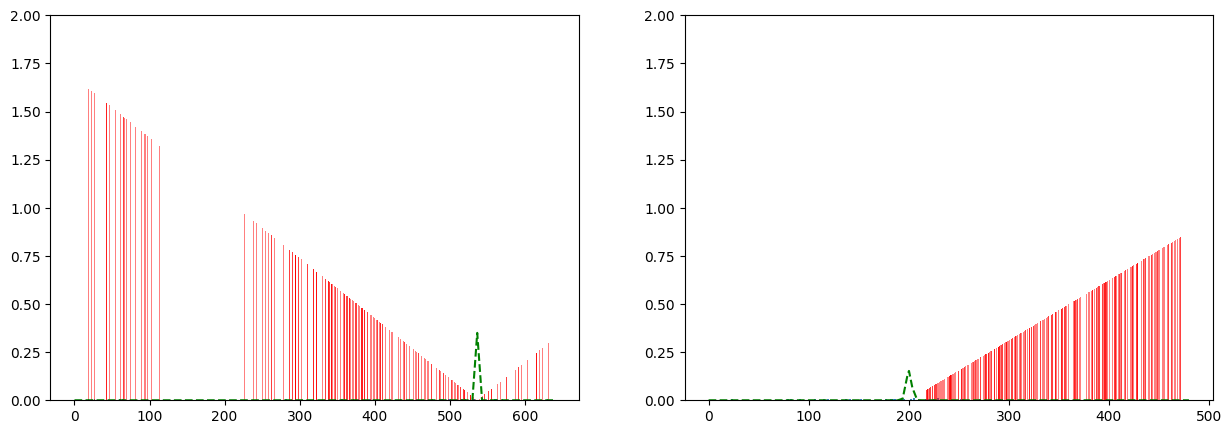

In [19]:
plot_p_and_var(346, pred['keypoints1'], pred['gt_proj_0to1'], pred['gt_res0_1_sq'], pred['p_rp_01'], pred['logvar_01'])

Max categorical weight 0.02047652192413807 and weight sum 1.0000001192092896
Minimum residual_sq x 0.01906282640993595
Minimum residual_sq y 1.956246256828308
Weigted residual_sq sum x 8844.0703125
Weigted residual_sq sum y 13470.6767578125
Var x: 1.6932209730148315, Var y: 3.6361052989959717


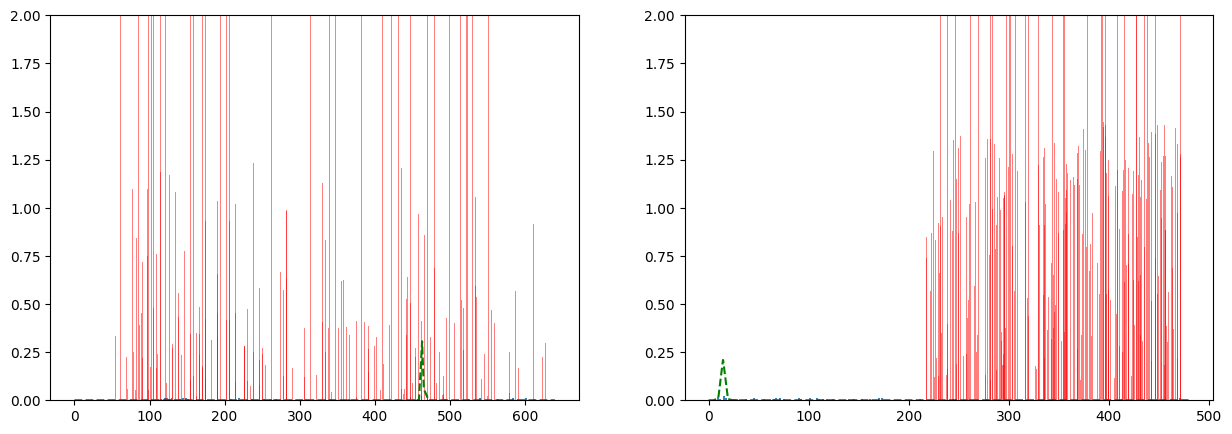

In [20]:
plot_p_and_var(266, pred['keypoints0'], pred['gt_proj_1to0'], pred['gt_res1_0_sq'], pred['p_rp_10'], pred['logvar_10'], tp = True)

In [21]:

def plot_var_stats(var):
    print(f'Max and Min and Median var_01 x: {var[:, 0].max()}, {var[:, 0].min()}, {var[:, 0].median()}')
    print(f'Max and Min and Median var_01 y: {var[:, 1].max()}, {var[:, 1].min()}, {var[:, 1].median()}')
    var= var.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(var[:, 0], bins=100)
    ax2.hist(var[:, 1], bins=100)

In [22]:
pred['logvar_10'].squeeze()[:,:1].min(0)

torch.return_types.min(
values=tensor([-1.0808], grad_fn=<MinBackward0>),
indices=tensor([379]))

In [23]:
pred['logvar_10'].mean()

tensor(0.8256, grad_fn=<MeanBackward0>)

Max and Min and Median var_01 x: 12.138896942138672, 0.36581000685691833, 1.783826470375061
Max and Min and Median var_01 y: 12.864287376403809, 0.4842076301574707, 3.2225229740142822


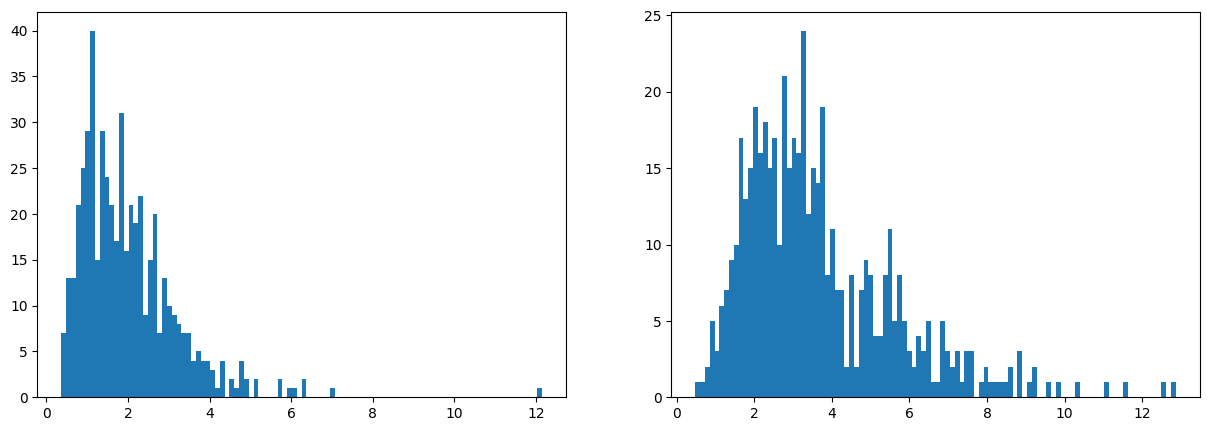

In [24]:
var_01 = torch.exp(pred['logvar_01']).squeeze().detach().cpu()
plot_var_stats(var_01)

Max and Min and Median var_01 x: 6.892995357513428, 0.3393099009990692, 1.7396577596664429
Max and Min and Median var_01 y: 10.5623197555542, 0.6434579491615295, 3.1850011348724365


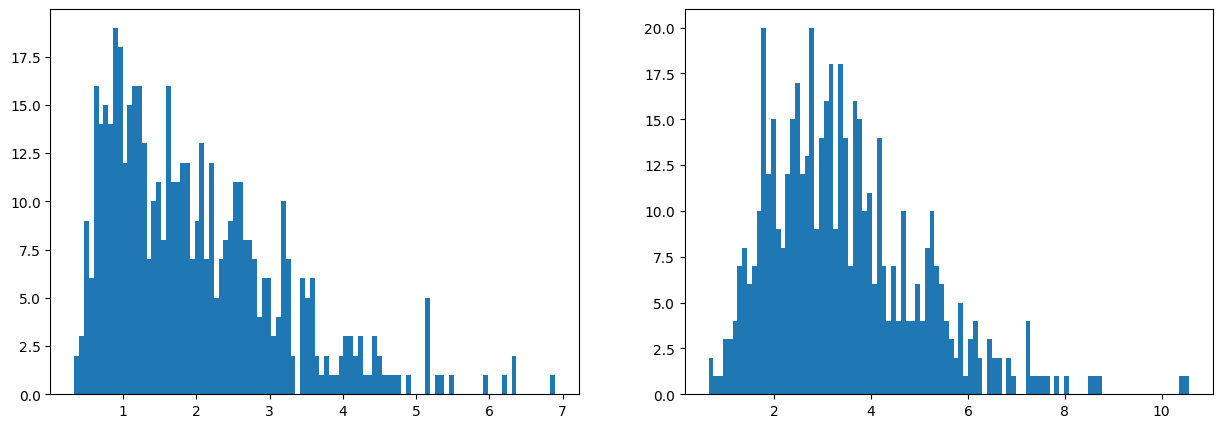

In [25]:
var_10 = torch.exp(pred['logvar_10']).squeeze().detach().cpu()
plot_var_stats(var_10)

In [26]:
for k in data['view0']:
    print(k)

image
H_
coords
image_size


In [27]:
data['view0']['image_size'].shape

torch.Size([1, 2])

In [28]:
import cv2

def draw_keypoints_cv(image, kps, color = (0, 255, 0), select_kp = None):
  if image.shape[1] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
    image = (image * scale).sum(1, keepdim=True)
  image = image.squeeze().detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.squeeze().detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)

  if select_kp is not None:
    for kp in select_kp:
      cv2.circle(out_img, (int(kps[kp][0]), int(kps[kp][1])), 5, (255, 0, 0), -1)

  return out_img

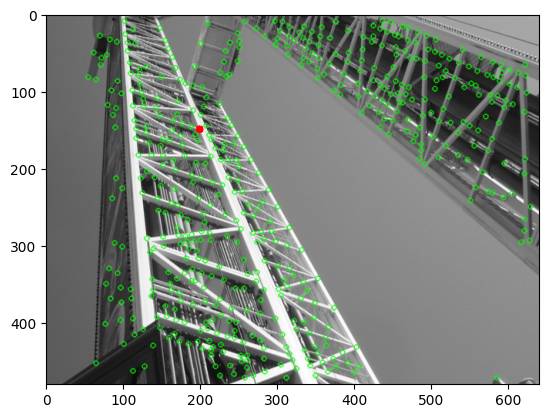

In [29]:
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0), select_kp=[0])
plt.imshow(img0)
plt.show()

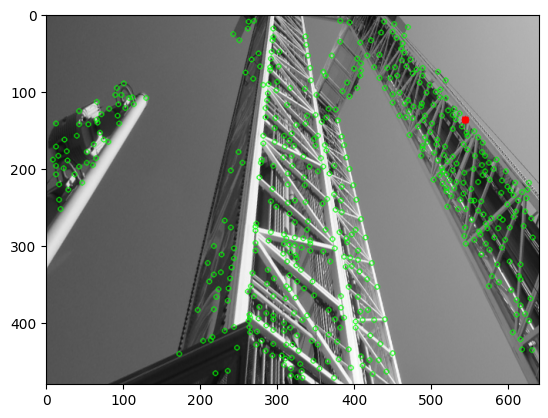

In [30]:
img1 = draw_keypoints_cv(data['view1']['image'], pred['keypoints1'], color=(0,255,0), select_kp=[266])
plt.imshow(img1)
plt.show()

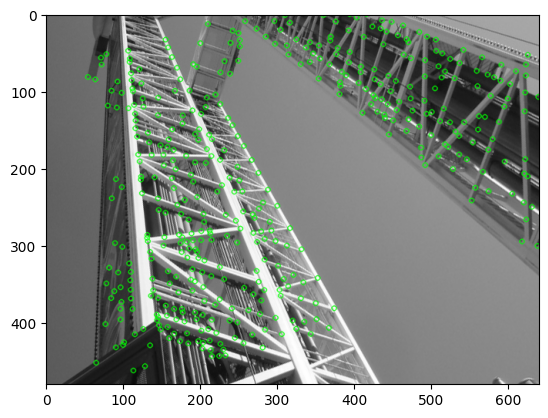

In [31]:
img1_0 = draw_keypoints_cv(data['view0']['image'], pred['gt_proj_1to0'], color=(0,255,0))
plt.imshow(img1_0)
plt.show()

In [32]:
import torch

In [33]:
kpts0 = torch.ones((3,5,2))
kpts1 = torch.ones((3,5,2))

res0_1_sq = (kpts0.unsqueeze(-2) - kpts1.unsqueeze(-3)) ** 2
print(res0_1_sq.shape)


torch.Size([3, 5, 5, 2])


In [34]:
kpts0.shape

torch.Size([3, 5, 2])

In [35]:
vis0 = torch.ones((3,5), dtype=torch.bool)
vis1 = torch.ones((3,5), dtype=torch.bool)
mask_visible = vis0.unsqueeze(-1) & vis1.unsqueeze(-2)
print(mask_visible.shape)


torch.Size([3, 5, 5])


In [36]:
kpts0_new = torch.where(vis0.unsqueeze(-1), kpts0, 3)